In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from models.addmul import HandleAddMul

In [2]:
network_cache_dir = "networks/cache-networks/"
network_name = "lyr256-split0.8-lr0.01-add-mul.data"

checkpoint = True
test_flag = 1

input_dims = [42]
output_dims = [20]
batchsize = 128
tau = 1  # temperature parameter, NB: check for value in paper

handler = HandleAddMul(input_dims, output_dims, dir=network_cache_dir + network_name, checkpoint=checkpoint, lr=0.001)

... FNN Network training on cuda:0 ...
Accessing : networks/cache-networks/lyr256-split0.8-lr0.01-add-mul.data
networks/cache-networks/lyr256-split0.8-lr0.01-add-mul.data
Load saves ...


# Test the Add mask

tensor([[0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        ...,
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        ...,
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        [0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)
tensor([[0.0296, 0.0296, 0.0296,  ..., 0.0296, 0.0296, 0.0296],
        [0.0296, 0.0296, 0.0296,  ..

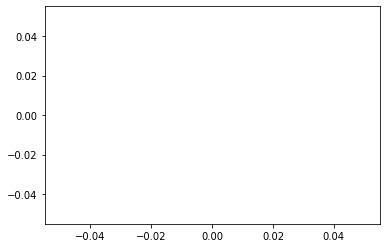

In [67]:

# Fetch Mask
load_logits = torch.load('masks/trained_logits_add_mask.pt')

binary_mask = []
all_logits = []
for layer in load_logits:
    sig = torch.sigmoid(layer)
    print(sig)

    greaterthan = torch.ge(sig, 0.5)
    
    all_logits.append(torch.masked_select(sig, greaterthan).view(-1).cpu().detach().numpy())
    binary_mask.append(greaterthan.float())

# for b in binary_mask:
#     print(len(b[b != 0]))
    
import matplotlib.pyplot as plt
plt.plot(np.concatenate(all_logits))
plt.show()


In [31]:
train_split = 0.8
test_split = 1 - train_split

data_fp = ["generate_datasets/tmp/digit-data/simple_add.npy",
           "generate_datasets/tmp/digit-data/simple_mul.npy"]
data_add = np.load(data_fp[0], allow_pickle=True)
data_mul = np.load(data_fp[1], allow_pickle=True)
data_add_len = len(data_add)
data_mul_len = len(data_mul)

train_split_idx_add = int(data_add_len * train_split)
train_split_idx_mul = int(data_mul_len * train_split)
test_data_add = data_add[train_split_idx_add:]
test_data_mul = data_mul[train_split_idx_mul:]

test_loader_add = torch.utils.data.DataLoader(dataset=torch.Tensor(test_data_add), batch_size=batchsize, shuffle=True)
test_loader_mul = torch.utils.data.DataLoader(dataset=torch.Tensor(test_data_mul), batch_size=batchsize, shuffle=True)

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

iterator_test_add = iter(cycle(test_loader_add))
iterator_test_mul = iter(cycle(test_loader_mul))

In [17]:
loss_hist = []
NUM_EPOCHS = 100

mul_acc = 0.
add_acc = 0.

for e in range(NUM_EPOCHS):
    print(f'Starting epoch {e}...')

    '''Call Addition Mask'''
    iterator_binaries = iter(binary_mask)
    batch_add = next(iterator_test_add)
    batch_mul = next(iterator_test_mul)
    
    batches = [batch_add, batch_mul]
    
    with torch.no_grad():
        for layer in handler.network.layers[0]:
            if isinstance(layer, torch.nn.Linear):
                layer.weight.mul_(next(iterator_binaries))

        '''Pass Testing batches through the network'''
        res = [] 
        for batch in batches:
            # Load in batch data (not binaries for one-hot input)
            
            inp = torch.stack([torch.stack([b[0], b[1]]) for b in batch])
            otp = torch.stack([b[2] for b in batch])
            ops = torch.stack([b[3] for b in batch])
            # Convert batch data toone-hot representation
            inp, _ = handler.set_batched_digits(inp, otp, ops)

            inp_ = inp.to(handler.network.device)
            
            otp = otp.to(handler.network.device)

            otp_pred = handler.network(inp_)
            
            otp_pred = torch.stack([otp_pred[:,:10], otp_pred[:,10:]], dim=1)
            otp_pred = torch.argmax(otp_pred, dim=2)
            otp_pred = otp_pred[:, 0]*10 + otp_pred[:, 1]
            res.append([otp_pred, otp])
    
        for i, results in enumerate(res):
            
            diff = results[1] - results[0]
            running_acc = float(len(diff[diff == 0])/(diff.size()[0]))
            if not i:
                add_acc += running_acc
            else:
                mul_acc += running_acc

print(f'Add Accuracy: {add_acc/NUM_EPOCHS} \n Mul Accuracy: {mul_acc/NUM_EPOCHS}')

Starting epoch 0...
Starting epoch 1...
Starting epoch 2...
Starting epoch 3...
Starting epoch 4...
Starting epoch 5...
Starting epoch 6...
Starting epoch 7...
Starting epoch 8...
Starting epoch 9...
Starting epoch 10...
Starting epoch 11...
Starting epoch 12...
Starting epoch 13...
Starting epoch 14...
Starting epoch 15...
Starting epoch 16...
Starting epoch 17...
Starting epoch 18...
Starting epoch 19...
Starting epoch 20...
Starting epoch 21...
Starting epoch 22...
Starting epoch 23...
Starting epoch 24...
Starting epoch 25...
Starting epoch 26...
Starting epoch 27...
Starting epoch 28...
Starting epoch 29...
Starting epoch 30...
Starting epoch 31...
Starting epoch 32...
Starting epoch 33...
Starting epoch 34...
Starting epoch 35...
Starting epoch 36...
Starting epoch 37...
Starting epoch 38...
Starting epoch 39...
Starting epoch 40...
Starting epoch 41...
Starting epoch 42...
Starting epoch 43...
Starting epoch 44...
Starting epoch 45...
Starting epoch 46...
Starting epoch 47...
St